In [2]:
%pylab inline
import numpy as np
import timeit


import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%load_ext Cython
import Cython.Compiler.Options as CO
CO.extra_compile_args = ['-O3']
CO.extra_link_args = ['-O3']

# Bilateral filter

Theory from [this paper](http://people.csail.mit.edu/sparis/publi/2009/fntcgv/Paris_09_Bilateral_filtering.pdf)

**Why not on GPU?**

This project seem to fit better GPU calculation. However, developping on CPU permits to use the memory hierarchy more than using GPU. Indeed the cache is bigger in the CPU which permits to get more context for a pixel in cache.  

As seen in this image from the class (credit Ray Thouis Jones): 

![credit Ray Thouis Jones](cacheCPUvsGPU.png)

Using the SIMD of AVX allows us to optimize performance on CPU calculation. However, this will be true only if the algorithm is **computation bound** and not **memory bound**. That is why we will pay special care to memory optimization in this project.


## input parameters

In [4]:
im_size = 64
sigma_r = 2.
sigma_s = 2.
truncate = 4.
lw = int(max(sigma_r, sigma_s)*truncate)

## generate image

<matplotlib.colorbar.Colorbar instance at 0x7f9babdf5758>

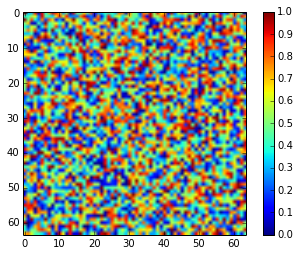

In [5]:
picture = np.random.random((im_size, im_size))
plt.imshow(picture);
plt.colorbar()

## helper function

In [6]:
def gaussian(x2, sigma):
    """get gaussian coefficient with x^2 as input"""
    return np.exp(-.5*x2/sigma**2)

The bilateral filter takes 2 inputs (and one optional):

 - sigma_r is the standard deviation of the bilateral filter
 - sigma_s is the standard deviation of the gaussian blur
 - truncate is the value at which we truncate. This is an optimization. We assume that the coefficient are negligeable at max(sigma)*truncate since the gaussian shape is exponentially decaying.

# First approach (more flexible)

## preprocess

Here we pad around the input picture. This is necessary because we will take a window around the picture to compute its output value. In the current implementation we use the numpy.pad function and we use the 'reflect mode'.

We need to fit a multiple of 8 in the direction where we use AVX arrays. Here is a picture to better explain this idea.

![](input_preprocessing.PNG)

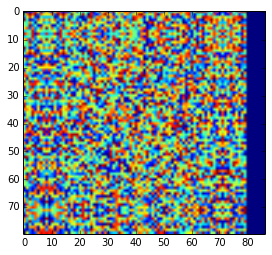

In [7]:
imsize = np.shape(picture)
input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')
plt.imshow(input_im);

## filter algorithm

2 level of parallelism:

+ for each line in the window do a prange as showed in the picture

![](prange_in_window.PNG)


+ within the line use AVX

Nota Bene (illustrated in the figure below):

- [i,j] index in input_im
- [i-lw, j-lw]index in output

![ij](ij_loop.PNG)







We load data by chunk of 8 (so that we can replace it with AVX array afterwards). See the design on the picture:
![](AVX_columnwise.PNG)



In [8]:
start = time.time()
output = picture * 0

# to implement with multi process
for i in range(lw, imsize[0] + lw):
    for j in range(lw, imsize[1] + lw):

        # window contining halo
        window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
        assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
        windowsize = np.shape(window)
        
        # initialize normalization term and output term
        sumg = 0
        local_output = 0
        I_pixel = window[lw, lw]
        
        for k in range(windowsize[0]):
            for l in range(0, windowsize[1], 8):
                # take local_input which will become an AVX 8-array
                local_input = window[k,l:l+8]
                assert np.size(local_input) == 8
                
                for cur in range(8):
                    # don't consider the pixel if it is outside the window
                    if l + cur < 2 * lw + 1:
                        coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
#                         coef *= gaussian((local_input[cur] - I_pixel)**2, sigma_r)
                        local_output += coef * local_input[cur]
                        sumg += coef
        
        output[i-lw, j-lw] = local_output / sumg

print "python ", time.time() - start

python  12.6587870121


scipy 0.00552606582642


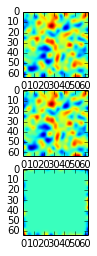

In [9]:
plt.subplot(311)
# our algorithm for gaussian filter
plt.imshow(output);
# plt.colorbar()

plt.subplot(312)
# scipy
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
start = time.time()
blur = gaussian_filter(picture, 2)
plt.imshow(blur);
# plt.colorbar()
print "scipy", time.time() - start

plt.subplot(313)
# the difference
plt.imshow(blur-output)
# plt.colorbar()

### Cython

In [10]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
# cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)

           
cpdef bilateral_filter_nopr(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw):

    cdef:
        int i,j,k,l,cur
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        float sumg, local_output, I_pixel, coef

    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        for j in range(lw, imsize1 + lw):

            # window contining halo
            window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
            if np.shape(window) != (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8):
                print np.shape(window) , (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
            assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
            windowsize0, windowsize1 = np.shape(window)

            # initialize normalization term and output term
            sumg = 0
            local_output = 0
            I_pixel = window[lw, lw]

            for k in range(windowsize0):
                for l in range(0, windowsize1, 8):
                    # take local_input which will become an AVX 8-array
                    local_input = window[k,l:l+8]
                    assert np.size(local_input) == 8

                    for cur in range(8):
                        # don't consider the pixel if it is outside the window
                        if l + cur < 2 * lw + 1:
                            coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                            coef *= gaussian((<float> local_input[cur] - I_pixel)**2, sigma_r)
                            local_output += coef * <float> local_input[cur]
                            sumg += coef

            output[i-lw, j-lw] = local_output / sumg


### prange

From [documentation](http://docs.cython.org/src/userguide/parallelism.html)

*cython.parallel.prange([start,] stop[, step][, nogil=False][, schedule=None[, chunksize=None]][, num_threads=None])*
This function can be used for parallel loops. OpenMP automatically starts a thread pool and distributes the work according to the schedule used. step must not be 0. This function can only be used with the GIL released. If nogil is true, the loop will be wrapped in a nogil section.

**Thread-locality and reductions are automatically inferred for variables.**

If you assign to a variable in a prange block, it becomes lastprivate, meaning that the variable will contain the value from the last iteration. If you use an inplace operator on a variable, it becomes a reduction, meaning that the values from the thread-local copies of the variable will be reduced with the operator and assigned to the original variable after the loop. The index variable is always lastprivate. Variables assigned to in a parallel with block will be private and unusable after the block, as there is no concept of a sequentially last value.

**The schedule is passed to OpenMP and can be one of the following:**

- static:
If a chunksize is provided, iterations are distributed to all threads ahead of time in blocks of the given chunksize. If no chunksize is given, the iteration space is divided into chunks that are approximately equal in size, and at most one chunk is assigned to each thread in advance.

This is most appropriate when the scheduling overhead matters and the problem can be cut down into equally sized chunks that are known to have approximately the same runtime.

- dynamic:
The iterations are distributed to threads as they request them, with a default chunk size of 1.

This is suitable when the runtime of each chunk differs and is not known in advance and therefore a larger number of smaller chunks is used in order to keep all threads busy.

- guided:
As with dynamic scheduling, the iterations are distributed to threads as they request them, but with decreasing chunk size. The size of each chunk is proportional to the number of unassigned iterations divided by the number of participating threads, decreasing to 1 (or the chunksize if provided).

This has an advantage over pure dynamic scheduling when it turns out that the last chunks take more time than expected or are otherwise being badly scheduled, so that most threads start running idle while the last chunks are being worked on by only a smaller number of threads.

- runtime:
The schedule and chunk size are taken from the runtime scheduling variable, which can be set through the openmp.omp_set_schedule() function call, or the OMP_SCHEDULE environment variable. Note that this essentially disables any static compile time optimisations of the scheduling code itself and may therefore show a slightly worse performance than when the same scheduling policy is statically configured at compile time.


**Barrier**

At the end of every  prange(),
there is an implicit barrier. All threads must reach the barrier before
computation continues.

In [11]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
# cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)


cpdef bilateral_filter_pr(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw,
                        int num_thread):

    cdef:
        int i,j,k,l,cur, ii
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        float sumg, local_output, I_pixel, coef

    local_input = np.zeros(8, np.float32)


    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        for j in range(lw, imsize1 + lw):

            # window contining halo
            window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
            assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
            windowsize0, windowsize1 = np.shape(window)

            # initialize normalization term and output term
            sumg = 0
            local_output = 0
            I_pixel = window[lw, lw]

            for k in prange(windowsize0, nogil = True, num_threads=num_thread):
                for l in range(0, windowsize1, 8):
                    # take local_input which will become an AVX 8-array
                    for ii in range(8):
                        local_input[ii] = window[k,l+ii]
#                     assert np.size(local_input) == 8

                    for cur in range(8):
                        # don't consider the pixel if it is outside the window
                        if l + cur < 2 * lw + 1:
                            coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                            coef *= gaussian((<float> local_input[cur] - I_pixel)**2, sigma_r)
                            local_output += coef * <float> local_input[cur]
                            sumg += coef

            output[i-lw, j-lw] = local_output / sumg


### prange for j

In [12]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
# cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)


cpdef bilateral_filter_pr_j(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw):

    cdef:
        int i,j,k,l,cur, ii,ixx, xx, iyy, yy,_
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        float sumg, local_output, I_pixel, coef
        np.float32_t [:] partial_output, partial_sumg

    local_input = np.zeros(8, np.float32)
    window = np.zeros((2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8), np.float32)
    windowsize0, windowsize1 = np.shape(window)


    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        #initalize parameters
        partial_output = np.zeros(imsize1, np.float32)
        partial_sumg = np.zeros(imsize1, np.float32)

        for j in prange(lw, imsize1 + lw, nogil = True):

            # window contining halo
            for iyy, yy in enumerate(range(j - lw, j + 1 + lw + 8 - (2 * lw + 1) % 8)):
                for ixx, xx in enumerate(range(i - lw, i + lw + 1)):
                    window[ixx, iyy] = input_im[xx, yy]
#             window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
#             assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)


            # initialize normalization term and output term
            I_pixel = window[lw, lw]

            for k in range(windowsize0):
                for l in range(0, windowsize1, 8):
                    # take local_input which will become an AVX 8-array
                    for ii in range(8):
                        local_input[ii] = window[k,l+ii]
#                     assert np.size(local_input) == 8

                    for cur in range(8):
                        # don't consider the pixel if it is outside the window
                        if l + cur < 2 * lw + 1:
                            coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                            coef *= gaussian((<float> local_input[cur] - I_pixel)**2, sigma_r)
                            partial_output[j-lw] += coef * <float> local_input[cur]
                            partial_sumg[j-lw] += coef

        for _ in range(imsize1):
            output[i-lw, _] = partial_output[_] / partial_sumg[_]

### Optimization of memory

In [13]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
# cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)


cpdef bilateral_filter_pr_j(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw):

    cdef:
        int i,j,k,l,cur, ii,ixx, xx, iyy, yy,_
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        float sumg, local_output, I_pixel, coef
        np.float32_t [:] partial_output, partial_sumg

    local_input = np.zeros(8, np.float32)
    window = np.zeros((2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8), np.float32)
    windowsize0, windowsize1 = np.shape(window)


    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        #initalize parameters
        partial_output = np.zeros(imsize1, np.float32)
        partial_sumg = np.zeros(imsize1, np.float32)

        for j in prange(lw, imsize1 + lw, nogil = True):

            # window contining halo
            for iyy, yy in enumerate(range(j - lw, j + 1 + lw + 8 - (2 * lw + 1) % 8)):
                for ixx, xx in enumerate(range(i - lw, i + lw + 1)):
                    window[ixx, iyy] = input_im[xx, yy]
#             window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
#             assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)


            # initialize normalization term and output term
            I_pixel = window[lw, lw]

            for k in range(windowsize0):
                for l in range(0, windowsize1, 8):
                    # take local_input which will become an AVX 8-array
                    for ii in range(8):
                        local_input[ii] = window[k,l+ii]
#                     assert np.size(local_input) == 8

                    for cur in range(8):
                        # don't consider the pixel if it is outside the window
                        if l + cur < 2 * lw + 1:
                            coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                            coef *= gaussian((<float> local_input[cur] - I_pixel)**2, sigma_r)
                            partial_output[j-lw] += coef * <float> local_input[cur]
                            partial_sumg[j-lw] += coef

        for _ in range(imsize1):
            output[i-lw, _] = partial_output[_] / partial_sumg[_]

### performance

#### accuracy

bilateral without range 0.68736410141
bilateral with prange 2th 0.324504137039
bilateral with prange j 0.3348300457


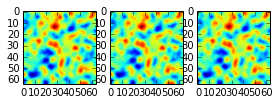

In [14]:
#run filter
num_thread =2
imsize0 = imsize[0]
imsize1 = imsize[1]
output = picture*0.
output5 =  np.array(output, np.float32)
input_im5 = np.array(input_im, np.float32)
start = time.time()
bilateral_filter_nopr(sigma_s,
                        sigma_r,
                        input_im5,
                        imsize0,
                        imsize1,
                        output5, 
                        lw)
print "bilateral without range", time.time() - start
plt.subplot(141)
plt.imshow(output5)

output = picture*0.
output5 =  np.array(output, np.float32)
input_im5 = np.array(input_im, np.float32)
start = time.time()
bilateral_filter_pr(sigma_s,
                        sigma_r,
                        input_im5,
                        imsize0,
                        imsize1,
                        output5, 
                        lw,
                   num_thread)
print "bilateral with prange 2th", time.time() - start
plt.subplot(142)
plt.imshow(output5)

output = picture*0.
output5 =  np.array(output, np.float32)
input_im5 = np.array(input_im, np.float32)
start = time.time()
bilateral_filter_pr_j(sigma_s,
                        sigma_r,
                        input_im5,
                        imsize0,
                        imsize1,
                        output5, 
                        lw)
print "bilateral with prange j", time.time() - start
plt.subplot(143)
plt.imshow(output5)

#### time

timing function
min
garbage collector
lecture on cache

In [25]:
def time_update(function, truncate, imsize, picture, input_im, lw, num_thread=None):
    
    #cython parameters
    imsize0 = imsize[0]
    imsize1 = imsize[1]
    output = picture*0.
    output5 =  np.array(output, np.float32)
    input_im5 = np.array(input_im, np.float32)
    
    if num_thread is None:
        times = timeit.repeat(lambda: function(sigma_s,
                                                        sigma_r,
                                                        input_im5,
                                                        imsize0,
                                                        imsize1,
                                                        output5, 
                                                        lw), 
                            number=3, repeat=5)
    else:
        times = timeit.repeat(lambda: function(sigma_s,
                                                    sigma_r,
                                                    input_im5,
                                                    imsize0,
                                                    imsize1,
                                                    output5, 
                                                    lw,
                                                    num_thread), 
                            number=3, repeat=5)
    print("{} = {}: {}".format(str(function),truncate , min(times)))

    return min(times)

In [59]:
#time without prange
iters = 10
functions = [bilateral_filter_nopr,bilateral_filter_pr,bilateral_filter_pr_j]
th = [None, 1, None]
truncates = [k for k in range(iters)] 


times = [[0 for truncate in truncates] for fn in functions]


for k, fn in enumerate(functions):
    print str(fn)
    for truncate in truncates:
        lw = (max(sigma_r, sigma_s)*truncate)

        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times[k][truncate] = time_update(fn, truncate, imsize, picture, input_im, lw, th[k])

<built-in function bilateral_filter_nopr>
<built-in function bilateral_filter_nopr> = 0: 0.102290153503
<built-in function bilateral_filter_nopr> = 1: 0.256357908249
<built-in function bilateral_filter_nopr> = 2: 0.690953016281
<built-in function bilateral_filter_nopr> = 3: 1.1258289814
<built-in function bilateral_filter_nopr> = 4: 1.97074604034
<built-in function bilateral_filter_nopr> = 5: 2.6903090477
<built-in function bilateral_filter_nopr> = 6: 3.96986913681
<built-in function bilateral_filter_nopr> = 7: 4.9345870018
<built-in function bilateral_filter_nopr> = 8: 6.64726901054
<built-in function bilateral_filter_nopr> = 9: 7.91880106926
<built-in function bilateral_filter_pr>
<built-in function bilateral_filter_pr> = 0: 0.0628550052643
<built-in function bilateral_filter_pr> = 1: 0.138499975204
<built-in function bilateral_filter_pr> = 2: 0.316035985947
<built-in function bilateral_filter_pr> = 3: 0.577615976334
<built-in function bilateral_filter_pr> = 4: 0.964755058289
<built-

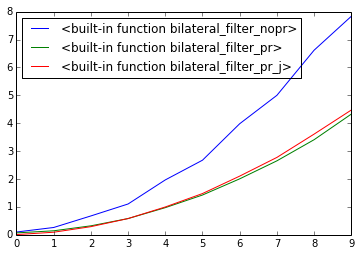

In [17]:
plt.plot(times[:][0], label = "{}".format(str(functions[0])))
plt.plot(times[:][1], label = "{}".format(str(functions[1])))
plt.plot(times[:][2], label = "{}".format(str(functions[2])))
plt.legend(loc="best")


#### Discussion

As expected we can see that the algorithm with prange is faster than the algorithm without prange. It is about twice faster.

The red curve corresponds to timing of the prange for j. And the green line corresponds to prange for k.
We see that the prange for j is performing slightly better than k in the beginning but after a truncation number of 4 prange for k performs better.

This must be due to the memory. prange for j is **memory bound**. The bigger the window is and the worse the effect on this prange will be because each thread needs to get the data for the window.

A potential optimization would be to load a larger window in the direction of j and to do the calculation more times with the data for the window **already in the cache and serialized**. Then we should tend towards a **compute bound**. Ideally we would like to see the effect of the cache size as the window size get bigger (which non linear and not exponential, as we did in class we should clearly see the difference between L1 and L2).


#### **About Serialization and I/O bound**

[Forum post](http://stackoverflow.com/questions/1685330/why-we-should-perfer-to-store-the-serialized-data-not-the-raw-code-to-db) and [discussion](https://mail.python.org/pipermail/cython-devel/2012-September/003159.html) about serialization. As seen in class, a serialization can be dealt with when using Python multiprocessing by sending slices(and not Cython openMP) which is a (efficent way to side-step)[https://docs.python.org/2/library/multiprocessing.html] the **[GIL](https://docs.python.org/2/glossary.html#term-global-interpreter-lock)**: "Global Interpreter Lock". We recall that the GIL prevents true multi-threading as seen in [article 1](http://www.jeffknupp.com/blog/2012/03/31/pythons-hardest-problem/) and [article 2](https://www.jeffknupp.com/blog/2013/06/30/pythons-hardest-problem-revisited/) by Jeff Knupp studied in class.

The trade-off is the following:

- Python multiprocess — high level, useful for I/Obound tasks but the double for loop we are doing for each pixel will might take too long if it is done in pure python.
- OpenMP Threading — low level, more efficient, fewer structures but can have a problem with I/O bound task

3 ways forwards:

1. optimize I/O using Cython prange (openMP) by doing some memory optimization
2. try to run Python multiprocessing sharing slices 
3. Use multithreading if we are really I/O bound. We can call a cython function that drops the GIL see [this piazza comment on HW2 P4](https://piazza.com/class/icqfmi2aryn6yv?cid=385) "The "with nogil:" section in median_3x3 drops the GIL, but continues to compute. This allows another Python thread to run (and enter that region, as well)."

#### Optimizing I/O with cython

Instead of loading a widow per pixel, we load a slightly bigger one (with 'offset' more columns). We take advantage of the fact that pixels in the same neighbourhood have windows that overlap a lot. Thus we make better use of the local (cached) data. This should improve the performance.

In [19]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
# cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)


cpdef bilateral_filter_pr_j_offset(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw,
                        int offset):

    cdef:
        int i,j,k,l,cur, ii,ixx, xx, iyy, yy,_,off
        # int offset = 4
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        float sumg, local_output, I_pixel, coef
        np.float32_t [:] partial_output, partial_sumg

    local_input = np.zeros(8, np.float32)
    window = np.zeros((2 * lw +1, offset + lw + 1 + lw + 8 - (2 * lw + 1) % 8), np.float32)
    windowsize0, windowsize1 = np.shape(window)
    windowsize1 = windowsize1 - offset


    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        #initalize parameters
        partial_output = np.zeros(imsize1, np.float32)
        partial_sumg = np.zeros(imsize1, np.float32)

        for j in prange(lw, imsize1 + lw, offset+1, nogil = True):

            # window contining halo (load for #offset pixels to take advantages of overlaps)
            for iyy, yy in enumerate(range(j - lw, offset + j + 1 + lw + 8 - (2 * lw + 1) % 8)):
                for ixx, xx in enumerate(range(i - lw, i + lw + 1)):
                    window[ixx, iyy] = (
                    input_im[xx, yy])
#             window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
#             assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)

            for off in range(offset+1):

                # initialize normalization term and output term
                I_pixel = window[lw, off + lw]

                for k in range(windowsize0):
                    for l in range(0, windowsize1, 8):
                        # take local_input which will become an AVX 8-array
                        for ii in range(8):
                            local_input[ii] = (
                            window[k,off + l+ii])
    #                     assert np.size(local_input) == 8

                        for cur in range(8):
                            # don't consider the pixel if it is outside the window
                            if l + cur < 2 * lw + 1:
                                coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                                coef *= gaussian((<float> local_input[cur] - I_pixel)**2, sigma_r)
                                partial_output[off + j-lw] += coef * <float> local_input[cur]
                                partial_sumg[off + j-lw] += coef

        for _ in range(imsize1):
            output[i-lw, _] = partial_output[_] / partial_sumg[_]


In [64]:
iters = 10
times_offset = np.zeros(iters)
truncates = [k for k in range(iters)] 

for k,truncate in enumerate(truncates):
        lw = (max(sigma_r, sigma_s)*truncate)

        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times_offset[k] = time_update(bilateral_filter_pr_j_offset, truncate, imsize, picture, input_im, lw, (2**3-1))

<built-in function bilateral_filter_pr_j_offset> = 0: 0.00629901885986
<built-in function bilateral_filter_pr_j_offset> = 1: 0.0847289562225
<built-in function bilateral_filter_pr_j_offset> = 2: 0.266997814178
<built-in function bilateral_filter_pr_j_offset> = 3: 0.534169912338
<built-in function bilateral_filter_pr_j_offset> = 4: 0.941632986069
<built-in function bilateral_filter_pr_j_offset> = 5: 1.38789010048
<built-in function bilateral_filter_pr_j_offset> = 6: 1.96838212013
<built-in function bilateral_filter_pr_j_offset> = 7: 2.62205004692
<built-in function bilateral_filter_pr_j_offset> = 8: 3.41517996788
<built-in function bilateral_filter_pr_j_offset> = 9: 4.2580769062


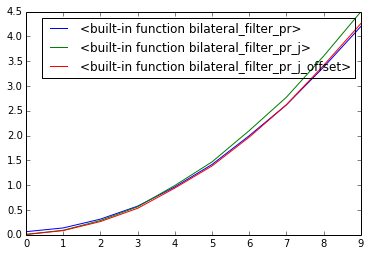

In [66]:
# plt.plot(times[:][0], label = "{}".format(str(functions[0])))
plt.plot(times[:][1], label = "{}".format(str(functions[1])))
plt.plot(times[:][2], label = "{}".format(str(functions[2])))
plt.plot(times_offset, label = "{}".format(str(bilateral_filter_pr_j_offset)))
plt.legend(loc="best")

With the implementation of the offset, we see that it performs better than the 2 prange for offset = 7 and a varying truncate number.

**Performance in function of the offset value**

In [27]:
def time_update_offset(function, truncate, imsize, picture, input_im, lw, num_thread=None):
    
    #cython parameters
    imsize0 = imsize[0]
    imsize1 = imsize[1]
    output = picture*0.
    output5 =  np.array(output, np.float32)
    input_im5 = np.array(input_im, np.float32)
    
    if num_thread is None:
        times = timeit.repeat(lambda: function(sigma_s,
                                                        sigma_r,
                                                        input_im5,
                                                        imsize0,
                                                        imsize1,
                                                        output5, 
                                                        lw), 
                            number=3, repeat=5)
    else:
        times = timeit.repeat(lambda: function(sigma_s,
                                                    sigma_r,
                                                    input_im5,
                                                    imsize0,
                                                    imsize1,
                                                    output5, 
                                                    lw,
                                                    num_thread), 
                            number=3, repeat=5)
    print("{} , {}: {}".format(str(function),num_thread , min(times)))

    return min(times)

In [36]:

truncate = 4
lw = (max(sigma_r, sigma_s)*truncate)
offsets = [0]
off = 1
while off<lw:
    off*=2
    offsets.append(off - 1)
off *= 2
offsets.append(off - 1)


for k,offset in enumerate(offsets):
        

        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times_offsets[k] = time_update_offset(bilateral_filter_pr_j_offset, truncate, imsize, picture, input_im, lw, offset)

<built-in function bilateral_filter_pr_j_offset> , 0: 0.992401123047
<built-in function bilateral_filter_pr_j_offset> , 1: 0.953453063965
<built-in function bilateral_filter_pr_j_offset> , 3: 0.934177160263
<built-in function bilateral_filter_pr_j_offset> , 7: 0.923645019531
<built-in function bilateral_filter_pr_j_offset> , 15: 0.916934967041


We see that the bigger the offset, the better.

# Other approach

Here we develop another approach that load data differently but that works only for a fixed set of parameters

In [68]:
# ##### About cache

# [This link](http://www.extremetech.com/extreme/188776-how-l1-and-l2-cpu-caches-work-and-why-theyre-an-essential-part-of-modern-chips)

# + lecture 09-23

# [on memoryview](http://docs.cython.org/src/userguide/memoryviews.html)

# [arrays in python](http://docs.cython.org/src/tutorial/array.html)

# [on cache performance](http://developerblog.redhat.com/2014/03/10/determining-whether-an-application-has-poor-cache-performance-2/)

# [hack1 to get perf](http://www.thegeekstuff.com/2010/06/chmod-command-examples/)

# [hack2 to get perf](http://ubuntuforums.org/showthread.php?t=1659623)

##### study of the cache in my machine

In [31]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False) 
@cython.wraparound(False)
@cython.initializedcheck(False)
cpdef long update_array(np.int64_t [::1] array, int len, long iters):
    cdef int offset = 0
    cdef int len_mask = len - 1
    with nogil:
        while iters > 0:
            array[offset] *= 3
            offset = (offset + 8) & len_mask
            iters -= 1
        

1K: 0.159004211426
2K: 0.158647060394
4K: 0.159144163132
8K: 0.158535957336
16K: 0.158592939377
32K: 0.159183979034
64K: 0.399250984192
128K: 0.399538040161
256K: 0.402219057083
512K: 0.570463895798
1024K: 1.46379208565
2048K: 2.15080904961
4096K: 2.06658196449
8192K: 2.22474908829
16384K: 2.09734797478
32768K: 2.17669892311


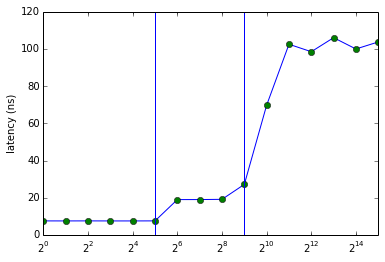

In [56]:
def time_update_cache(A, iters):
    times = timeit.repeat(lambda: update_array(A, A.size - 1, iters), number=3, repeat=5)
    print("{}K: {}".format(int(A.size * A.itemsize / 1024.0) , min(times)))
    return min(times)
sizes_bytes = np.array([1024 * (2 ** i) for i in range(16)])  # 1 K up to 32 MB
sizes = sizes_bytes / 8  # 8 bytes per int
iters = 5 * max(sizes)
arrays = [np.arange(sz, dtype=np.int64) for sz in sizes]
times = [time_update_cache(A, iters) for A in arrays]
semilogx(sizes_bytes / 1024.0, np.array(times) / iters * 1e9, basex=2)
semilogx(sizes_bytes / 1024.0, np.array(times) / iters * 1e9, 'o', basex=2)
axvline(32)    # L1 data cache
axvline(512)   # L2
# axvline(4192)  # L3
ylabel('latency (ns)')

##### the perf command on Linux

In [42]:
! perf list


List of pre-defined events (to be used in -e):
  cpu-cycles OR cycles                               [Hardware event]
  instructions                                       [Hardware event]
  cache-references                                   [Hardware event]
  cache-misses                                       [Hardware event]
  branch-instructions OR branches                    [Hardware event]
  branch-misses                                      [Hardware event]
  bus-cycles                                         [Hardware event]
  ref-cycles                                         [Hardware event]

  cpu-clock                                          [Software event]
  task-clock                                         [Software event]
  page-faults OR faults                              [Software event]
  context-switches OR cs                             [Software event]
  cpu-migrations OR migrations                       [Software event]
  minor-faults                           

In [52]:
! perf stat -e cache-misses,instructions ./another_driver.py

bilateral_AVX 26.4048190117
bilateral_AVX 10.7459759712

 Performance counter stats for './another_driver.py':

        11,161,973 cache-misses                                                
    61,462,903,733 instructions             

      44.973244776 seconds time elapsed



We will use the following command to study our cache performance by looking at the instruction to cache-misses ratio.

### With AVX

Advanced Vector Extensions (AVX) are extensions to the x86 instruction set architecture for microprocessors from Intel and AMD (from [Wikipedia](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions)). My computer actually uses another extension which SS3 (because it was built before 2011).

**More's law**

As seen in class, the number of transistors per chip has increased following More's exponential law. Though the clock time has not (transistors get smaller but heat cannot be sucked out of the chips fast enough for a given area, thus the temperature increases and the chip melts). AVX uses the paradigm of **[SIMD](https://en.wikipedia.org/wiki/SIMD)**: "Single Instruction Multiple Data". The same instruction is done  8-way-parallel on multiple data **without concurrency.**

From this graph (studied in class) we see that today, a substantial increase in performance is dur to SIMD.

![performance plot](whyAVX.png)

AVX enables a performance increase only if the algorithm is **computationally intensive/ [CPU bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean)** (a typical example is mandelbrot which was extensively studied in class. However it should not speed things up much if the algorithm is **[I/O bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean) (+ [Serialization](https://msdn.microsoft.com/en-us/library/ms233843.aspx))**! We will be able to check this in our optimization study of the I/O. We will try our best to use the memory effectively so that there is a real gain in using AVX.

**NB:** I could not find a hack to compile AVX program within iPython so I compiled it on my computer and just plot the code without running it.

... implementation of everything with AVX

### time and cache performance

...to do

In [33]:
from Ipython.display import HTML

ImportError: No module named Ipython.display

# Code implementations and optimization

## Introductory remarks

In the following part of the report we will introduce snippets of our code that don't run by themselves but that show the different things we tried to get better performances. All the function are written in seperate files and are called within this Ipython notebook. We will also consider performances.

Another remarks concerning the content of this report. We emphasized our work on the optimization of the code, the understanding of different concepts such as the memory behavious and the parallelism. We explore some implementations using AVX. However, we could not manage to code the exponential function in AVX. My computer has only SSE and has an AVX emulator. There are exp functions coded for AVX on the internet but they are not working with my emulator. As finding a hack to make work was starting to take too much of our time, we decided to move on in order to focus on concepts of the course and simply commenting out the lines where we take the exp of an AVX array. We could still benchmarck the accuracy of our code when we were not using AVX, in a first step with the Gaussian filter that we compared against a scipy function and for a bilateral filter using only cython and prange.

## Cython, AVX and Python multithreading

### Cython

You can see the documentation [here](http://docs.cython.org/). We specifically use:

- the fact that we can release the Global Interpreter Lock (GIL) with Cython. It will prove particularly useful in our multi-threaded implementation because it permits actual multi-threading.
- the cython implementation of OpenMP for parallelism, and more specifically [prange](http://docs.cython.org/src/userguide/parallelism.html). We will just remind that at the end of every  prange(),there is an implicit barrier. All threads must reach the barrier before computation continues, and there is no locks.



### AVX

Advanced Vector Extensions (AVX) are extensions to the x86 instruction set architecture for microprocessors from Intel and AMD (from [Wikipedia](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions)). My computer actually uses another extension which SS3 (because it was built before 2011).

**More's law**

As seen in class, the number of transistors per chip has increased following More's exponential law. Though the clock time has not (transistors get smaller but heat cannot be sucked out of the chips fast enough for a given area, thus the temperature increases and the chip melts). AVX uses the paradigm of **[SIMD](https://en.wikipedia.org/wiki/SIMD)**: "Single Instruction Multiple Data". The same instruction is done  8-way-parallel on multiple data **without concurrency.**

From this graph (studied in class) we see that today, a substantial increase in performance is dur to SIMD.

![performance plot](whyAVX.png)

AVX enables a performance increase only if the algorithm is **computationally intensive/ [CPU bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean)** (a typical example is mandelbrot which was extensively studied in class. However it should not speed things up much if the algorithm is **[I/O bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean) (+ [Serialization](https://msdn.microsoft.com/en-us/library/ms233843.aspx))**! We will be able to check this in our optimization study of the I/O. We will try our best to use the memory effectively so that there is a real gain in using AVX.

**NB:** I could not find a hack to compile AVX program within iPython so I compiled it on my computer and just plot the code without running it.

### Python multithreading

We use Python [threading](https://docs.python.org/2/library/threading.html) module. Multithreading permits us to share the image accross the threads. There is no local copy of the image which makes the code run faster.

One drawback of Python threading is that is cannot perform "real" multi-threading if a CPU-bound code is written in pure python because the GIL has to keep track of every Python objects. Though we dodge this short coming using "nogil=True" in Cython.

## Overview of the optimizations we have done

As a diagram is giagram is worth a thousand words, here is a diagram of bilateral filter:

In [38]:
HTML("<img src="./fig1.png" >")

SyntaxError: invalid syntax (<ipython-input-38-c79a1b825b21>, line 1)

Let's just emphasize that there are 2 part we will optimize (which are the next 2 paragraphs):

- Loop over the pixels of the output
- Computation of one pixel

### Loop over the pixels of the output

We have thought of 3 different ways to implement the double for loop over the pixels:

1. using one range on the rows and one range on the columns
2. using one range on the rows and one prange with steps of 8 for the columns (a further optimization does the whole step of 8 at once using AVX)
3. using python multithread to send the rows and use prange with steps of 8 for the columns and AVX: this is our best implementation regarding time.


### Computation for one pixel

In bilateral filter, you cannot just multiply a window by a kernel. A double for loop has to be done to sum up all the contributions of the pixels in the neighborhood to the computed output pixel.

We have though of 3 different ways to do these for loops:

1. using one prange on the rows and one range on the columns.
2. using one prange on the rows and one range with steps of 8 for the columns (a further optimization does the whole step of 8 at once using AVX)
3. using one range/prange  on the

## Our implementations

In this section we go through the different iterations and optimization of our algorithm. For each iteration we describe the algorithm and try to predict what the performance should be. We also do one run looking at the cache performence with the command line "! perf stat -e cache-misses,instructions ./driver_#function#.py 256 2 2 4".
Here:

- 256 stands for the number of pixel on one side of the image.
- 2 stands for sigma_s
- the other 2 stands for sigma_r
- 4 is the truncate number.

The driver function calls the function "time_update.py" which is a transformed version of the function we used in class to study cache. It uses the module timeit and takes the minimum time out of 5 run of the function 3 times. We take the min because we try to avoid the noise related Garbage Collector for example that could hamper the performance.

We then briefle discuss the performance however we will further run and discuss the performance in the next section.

###r_r1

**Description**

Here we do ranges for the loops over output pixels.

We also do ranges for the computation of one pixel. (Actually in the code one of the range has step 8 to prepare for a future implementation. We also need to care about the dimension of the window in order to get multiples of 8 as shown in the figure, we will use a mask ther with AVX).

![](fig7.png)

The crresponding code is:

**Prediction**

This is just a python code translated into cython. We have not looked at the performance of pure Python (because it is not relevant) but this implementation should be about twice faster. Also it should be one of the worst performance we will look at since we have not started to optimize yet.

In [23]:
! perf stat -e cache-misses,instructions ./driver_r_r1.py 256 2 2 4

<built-in function r_r1>: 31.082392931s

 Performance counter stats for './driver_r_r1.py 256 2 2 4':

        17,718,017 cache-misses                                                
   241,976,859,242 instructions             

     157.780398824 seconds time elapsed



In [43]:
print("The cache efficiency is {}".format(241976859242./17718017.))

The cache efficiency is 13657.107296


**Discussion**

Not much to be said, we will use it as a baseline.

###r_pr1

**Description**

Here we do ranges for the loops over output pixels.

We do pranges for the computation of one pixel.

**Prediction**

Here we are taking advantage of the 2 threads so it should be about twice faster.

In [24]:
! perf stat -e cache-misses,instructions ./driver_r_pr1.py 256 2 2 4

<built-in function r_pr1>: 12.3886418343s

 Performance counter stats for './driver_r_pr1.py 256 2 2 4':

        13,967,240 cache-misses                                                
   124,698,915,537 instructions             

      79.766505644 seconds time elapsed



In [46]:
print("The cache efficiency is {}".format(1./13967240.*124698915537.))

The cache efficiency is 8927.95681445


**Discussion**

We see that it goes more than twice faster. We also see that the cache performance is a little worse. It is hard to tell.

###r_AVX1

**Description**

Here we do ranges for the loops over output pixels.

We do pranges for the computation of one pixel and AVX implementation.

**Prediction**

Now if we are CPU bound and if there is not too much overhead it should go 8 times faster than the previous implementation.

In [42]:
! perf stat -e cache-misses,instructions ./driver_r_AVX1.py 256 2 2 4

<built-in function r_AVX1>: 15.9948129654s

 Performance counter stats for './driver_r_AVX1.py 256 2 2 4':

        33,212,160 cache-misses                                                
   115,518,094,928 instructions             

     107.889073329 seconds time elapsed



In [45]:
print("The cache efficiency is {}".format(1./33212160.*115518094928.))

The cache efficiency is 3478.18675232


**Discussion**

We see that it actually goes slower than prange. We also see that the cache performance is a little worse again. Maybe the image is too small to actually take benefit from AVX. In the next section we will see more test runs and might have a better idea.

###r_r2

**Description**

Here we do ranges for the loops over output pixels.


We also do ranges for the computation of one pixel. But this time we change the loading style as describe in the figure:
![](fig7.png)

This version is not as adapatable the product of sigma and truncate has to be a multiple of 8.

The corresponding code is:

**Prediction**

Here we are less flexible but we use all the data we load. The performance should be similar to the 1 design maybe a little better.

In [35]:
! perf stat -e cache-misses,instructions ./driver_r_r2.py 256 2 2 4

<built-in function r_r2>: 6.05780100822s

 Performance counter stats for './driver_r_r2.py 256 2 2 4':

         5,170,221 cache-misses                                                
    37,963,048,091 instructions             

      31.860130330 seconds time elapsed



In [47]:
print("The cache efficiency is {}".format(37963048091./5170221.))

The cache efficiency is 7342.63546781


In [ ]:
**Dis

###r_pr2

In [36]:
! perf stat -e cache-misses,instructions ./driver_r_pr2.py 256 2 2 4

<built-in function r_pr2>: 4.98243808746s

 Performance counter stats for './driver_r_pr2.py 256 2 2 4':

         4,308,946 cache-misses                                                
    52,375,886,992 instructions             

      27.731897613 seconds time elapsed



###r_AVX2

In [37]:
! perf stat -e cache-misses,instructions ./driver_r_AVX2.py 256 2 2 4

<built-in function r_AVX2>: 10.261026144s

 Performance counter stats for './driver_r_AVX2.py 256 2 2 4':

        14,266,201 cache-misses                                                
    77,077,728,472 instructions             

      66.787980376 seconds time elapsed



###prj_r1

In [29]:
! perf stat -e cache-misses,instructions ./driver_prj_r1.py 256 2 2 4

<built-in function prj_r1>: 8.23237800598s

 Performance counter stats for './driver_prj_r1.py 256 2 2 4':

         7,910,879 cache-misses                                                
    98,409,330,798 instructions             

      46.866586806 seconds time elapsed



###prj_AVX

In [30]:
! perf stat -e cache-misses,instructions ./driver_prj_AVX.py 256 2 2 4

<built-in function prj_AVX>: 3.45617198944s

 Performance counter stats for './driver_prj_AVX.py 256 2 2 4':

         5,707,750 cache-misses                                                
    39,358,375,376 instructions             

      22.125222766 seconds time elapsed



###step_r1

In [31]:
! perf stat -e cache-misses,instructions ./driver_step_r1.py 256 2 2 4

<built-in function step_r1>: 8.11321902275s

 Performance counter stats for './driver_step_r1.py 256 2 2 4':

         7,080,684 cache-misses                                                
    91,423,021,771 instructions             

      44.161211767 seconds time elapsed



###AVX_r

In [32]:
! perf stat -e cache-misses,instructions ./driver_AVX_r.py 256 2 2 4

<built-in function AVX_r>: 2.16228485107s

 Performance counter stats for './driver_AVX_r.py 256 2 2 4':

         5,902,434 cache-misses                                                
    25,993,617,895 instructions             

      14.082296152 seconds time elapsed



###mth_pr

In [34]:
! perf stat -e cache-misses,instructions ./driver_mth_pr.py 256 2 2 4

<built-in function mth_pr>: 1.3710360527s

 Performance counter stats for './driver_mth_pr.py 256 2 2 4':

         6,121,724 cache-misses                                                
    23,984,904,997 instructions             

       9.597764980 seconds time elapsed



# Benchmarking performances

We apply our algorithm to randomly generated pictures of varying pixel size. The parameters we change are the size of the picture. The value for the truncating variable, which determines the size of the window that we need for the computation of one pixel.

In [1]:
from r_r1 import * 
from r_pr1 import * 
from r_AVX1 import * 
from r_r2 import * 
from r_pr2 import * 
from r_AVX2 import * 
from prj_r1 import * 
from prj_AVX import * 
from step_r1 import * 
from AVX_r import * 
from mth_pr import *

ImportError: No module named r_r1